In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [226]:
def RILAcapBuffer(data, start_year, end_year, cap, typef, buffer, duration, participationRate = 1):

    startyear = start_year
    # Set index and convert date column to datetime
    data.set_index('Date', inplace=True)
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])

    RILA = []
    #curRILA = 1
    CAGR = []

    while start_year + duration <= end_year:
        CurYearData = data[data['Date'].dt.year == start_year]
        CurYearData.reset_index(inplace=True)
        CurYearData = CurYearData['Adj Close']
        NextYearData = data[data['Date'].dt.year == start_year + duration]
        NextYearData.reset_index(inplace=True)
        NextYearData = NextYearData['Adj Close']
        totalInc = 0
        for i in range(0, len(CurYearData) - 1):
            inc = NextYearData[i] / CurYearData[i] - 1
            if inc <= 0 and inc > 0 - buffer: 
                inc = 0
            elif inc <= 0 - buffer:
                inc = inc + buffer
            elif inc > 0:
                inc = inc * participationRate
                if inc > cap:
                    inc = cap
            totalInc += inc
        totalInc /= len(NextYearData)
            
        #curRILA *= (1 + totalInc)
        RILA.append(totalInc * 100)
        start_year += 1

    start_year = startyear  # Reset start_year to its initial value
    yearList = []
    while start_year + duration <= end_year:
        endYear = start_year + duration
        yearList.append(f"{start_year}-{endYear}")
        CurYearData = data[data['Date'].dt.year == start_year]
        CurYearData.reset_index(inplace=True)
        CurYearData = CurYearData['Adj Close']
        NextYearData = data[data['Date'].dt.year == endYear]
        NextYearData.reset_index(inplace=True)
        NextYearData = NextYearData['Adj Close']
        totalInc = 0
        for i in range(0, len(CurYearData) - 1):
            inc = ((NextYearData[i] / CurYearData[i]) - 1) * 100
            totalInc += inc
        CAGR.append(totalInc / len(NextYearData))
        start_year += 1

    # Plot results
    plt.figure(figsize=(14, 7))

    # Add labels for CAGR
    avg_CAGR = np.mean(CAGR)
    avg_RILAout = np.mean(RILA)
    ymax = max(np.max(CAGR), np.max(RILA))
    ymin = min(np.min(CAGR), np.min(RILA))
    comp = (ymax - ymin) / 20

    for i, txt in enumerate(CAGR):
        curdif = CAGR[i] - RILA[i]
        if curdif > 0 and curdif < comp:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        elif curdif < 0 and curdif > - comp:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
    for i, txt in enumerate(RILA):
        curdif = CAGR[i] - RILA[i]
        if curdif > 0 and curdif < comp:
            plt.text(yearList[i], CAGR[i] - comp, f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        elif curdif < 0 and curdif > - comp:
            plt.text(yearList[i], CAGR[i] + comp, f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(yearList[i], RILA[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)

    # Add labels for RILA
    # for i, txt in enumerate(RILA):
    #     curdif = RILA[i] - comp[i]
    #     plt.text(yearList[i], RILA[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)

    if cap >= 50:
        plt.text(yearList[-1], ymax - 5 * comp, f'Note: RILA Cap: Unlimited, Buffer: {buffer*100:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)
    else:
        plt.text(yearList[-1], ymax - 5 * comp, f'Note: RILA Cap: {cap*100:.2f}%, Buffer: {buffer*100:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)

    plt.title(f'Comparison of {typef} Annual Return and RILA Return Performance Strategy')
    plt.plot(yearList, CAGR, label=f'{typef} Annual Return')
    plt.plot(yearList, RILA, label=f'RILA Return-{typef} Annual point to point')
    plt.text(yearList[-1], ymax - comp, f'Average {typef} Annual Return: {avg_CAGR:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)
    plt.text(yearList[-1], ymax - 7 * comp, f'Participation Rate: {participationRate*100:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)
    plt.text(yearList[-1], ymax - 3 * comp, f'Average {typef} RILA Return: {avg_RILAout:.2f}%', color='orange', ha='right', va='top', fontsize=10)

    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
    plt.ylim(ymin, ymax)
    plt.tight_layout()  # Adjust layout to make room for x-axis labels
    plt.show()

    CAGR = [f"{value:.2f}%" for value in CAGR]
    RILA = [f"{value:.2f}%" for value in RILA]
    if cap >= 50:
        newData = {
            "Year List": yearList,
            f"Average {typef} Annual Return": CAGR,
            f'Average {typef} RILA Return': RILA,
            f'Note: RILA Cap: Unlimited, Buffer: {buffer*100:.2f}%': [""] * len(RILA)
        }
    else:
        newData = {
            "Year List": yearList,
            f"Average {typef} Annual Return": CAGR,
            f'Average {typef} RILA Return': RILA,
            f'Note: RILA Cap: {cap*100:.2f}%, Buffer: {buffer*100:.2f}%': [""] * len(RILA)
        }
    df = pd.DataFrame(newData)
    df.to_excel('RILAcapBuffer.xlsx', engine='openpyxl', index=False)
    

In [227]:
def RILAcapFloor(data, start_year, end_year, cap, typef, buffer, duration, participationRate = 1):

    startyear = start_year
    # Set index and convert date column to datetime
    data.set_index('Date', inplace=True)
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])

    RILA = []
    #curRILA = 1
    CAGR = []

    while start_year + duration <= end_year:
        CurYearData = data[data['Date'].dt.year == start_year]
        CurYearData.reset_index(inplace=True)
        CurYearData = CurYearData['Adj Close']
        NextYearData = data[data['Date'].dt.year == start_year + duration]
        NextYearData.reset_index(inplace=True)
        NextYearData = NextYearData['Adj Close']
        totalInc = 0
        for i in range(0, len(CurYearData) - 1):
            inc = NextYearData[i] / CurYearData[i] - 1
            if inc <= 0 - buffer:
                inc = 0 - buffer
            elif inc > 0:
                inc = inc * participationRate
                if inc > cap:
                    inc = cap
            totalInc += inc
        totalInc /= len(NextYearData)
            
        #curRILA *= (1 + totalInc)
        RILA.append(totalInc * 100)
        start_year += 1

    start_year = startyear  # Reset start_year to its initial value
    yearList = []
    while start_year + duration <= end_year:
        endYear = start_year + duration
        yearList.append(f"{start_year}-{endYear}")
        CurYearData = data[data['Date'].dt.year == start_year]
        CurYearData.reset_index(inplace=True)
        CurYearData = CurYearData['Adj Close']
        NextYearData = data[data['Date'].dt.year == endYear]
        NextYearData.reset_index(inplace=True)
        NextYearData = NextYearData['Adj Close']
        totalInc = 0
        for i in range(0, len(CurYearData) - 1):
            inc = ((NextYearData[i] / CurYearData[i]) - 1) * 100
            totalInc += inc
        CAGR.append(totalInc / len(NextYearData))
        start_year += 1

    # Plot results
    plt.figure(figsize=(14, 7))

    ymax = max(np.max(CAGR), np.max(RILA))
    ymin = min(np.min(CAGR), np.min(RILA))
    comp = (ymax - ymin) / 20
    # Add labels for CAGR
    for i, txt in enumerate(CAGR):
        curdif = CAGR[i] - RILA[i]
        if curdif > 0 and curdif < comp:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        elif curdif < 0 and curdif > - comp:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
    for i, txt in enumerate(RILA):
        curdif = CAGR[i] - RILA[i]
        if curdif > 0 and curdif < comp:
            plt.text(yearList[i], CAGR[i] - comp, f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        elif curdif < 0 and curdif > - comp:
            plt.text(yearList[i], CAGR[i] + comp, f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(yearList[i], RILA[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)

    avg_CAGR = np.mean(CAGR)
    avg_RILAout = np.mean(RILA)

    if cap >= 50:
        plt.text(yearList[-1], ymax - 5 * comp, f'Note: RILA Cap: Unlimited, Floor: {buffer*100:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)
    else:
        plt.text(yearList[-1], ymax - 5 * comp, f'Note: RILA Cap: {cap*100:.2f}%, Floor: {buffer*100:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)
        
    plt.title(f'Comparison of {typef} Annual Return and RILA Return Guard Strategy')
    plt.plot(yearList, CAGR, label=f'{typef} Annual Return')
    plt.plot(yearList, RILA, label=f'RILA Return-{typef} Annual point to point')
    plt.text(yearList[-1], ymax - comp, f'Average {typef} Annual Return: {avg_CAGR:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)
    plt.text(yearList[-1], ymax - 3 * comp, f'Average {typef} RILA Return: {avg_RILAout:.2f}%', color='orange', ha='right', va='top', fontsize=10)

    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
    plt.ylim(ymin, ymax)
    plt.tight_layout()  # Adjust layout to make room for x-axis labels
    plt.show()

    CAGR = [f"{value:.2f}%" for value in CAGR]
    RILA = [f"{value:.2f}%" for value in RILA]
    newData = {
        "Year List": yearList,
        f"Average {typef} Annual Return": CAGR,
        f'Average {typef} RILA Return': RILA,
        f'Note: RILA Cap: {cap*100:.2f}%, Floor: {buffer*100:.2f}%': [""] * len(RILA)
    }
    df = pd.DataFrame(newData)
    df.to_excel('RILAcapFloor.xlsx', engine='openpyxl', index=False)

In [228]:
def RILATriggerBuffer(data, start_year, end_year, cap, typef, buffer, duration, participationRate = 1):

    startyear = start_year
    # Set index and convert date column to datetime
    data.set_index('Date', inplace=True)
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])

    RILA = []
    #curRILA = 1
    CAGR = []

    while start_year + duration <= end_year:
        CurYearData = data[data['Date'].dt.year == start_year]
        CurYearData.reset_index(inplace=True)
        CurYearData = CurYearData['Adj Close']
        NextYearData = data[data['Date'].dt.year == start_year + duration]
        NextYearData.reset_index(inplace=True)
        NextYearData = NextYearData['Adj Close']
        totalInc = 0
        for i in range(0, len(CurYearData) - 1):
            inc = NextYearData[i] / CurYearData[i] - 1
            if inc <= 0 and inc > 0 - buffer: 
                inc = 0
            elif inc <= 0 - buffer:
                inc = inc + buffer
            elif inc > 0:
                inc = cap
            totalInc += inc
        totalInc /= len(NextYearData)
            
        #curRILA *= (1 + totalInc)
        RILA.append(totalInc * 100)
        start_year += 1

    start_year = startyear  # Reset start_year to its initial value
    yearList = []
    while start_year + duration <= end_year:
        endYear = start_year + duration
        yearList.append(f"{start_year}-{endYear}")
        CurYearData = data[data['Date'].dt.year == start_year]
        CurYearData.reset_index(inplace=True)
        CurYearData = CurYearData['Adj Close']
        NextYearData = data[data['Date'].dt.year == endYear]
        NextYearData.reset_index(inplace=True)
        NextYearData = NextYearData['Adj Close']
        totalInc = 0
        for i in range(0, len(CurYearData) - 1):
            inc = ((NextYearData[i] / CurYearData[i]) - 1) * 100
            totalInc += inc
        CAGR.append(totalInc / len(NextYearData))
        start_year += 1

    # Plot results
    plt.figure(figsize=(14, 7))

    # Add labels for CAGR
    ymax = max(np.max(CAGR), np.max(RILA))
    ymin = min(np.min(CAGR), np.min(RILA))
    comp = (ymax - ymin) / 20
    # Add labels for CAGR
    for i, txt in enumerate(CAGR):
        curdif = CAGR[i] - RILA[i]
        if curdif > 0 and curdif < comp:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        elif curdif < 0 and curdif > - comp:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
    for i, txt in enumerate(RILA):
        curdif = CAGR[i] - RILA[i]
        if curdif > 0 and curdif < comp:
            plt.text(yearList[i], CAGR[i] - comp, f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        elif curdif < 0 and curdif > - comp:
            plt.text(yearList[i], CAGR[i] + comp, f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(yearList[i], RILA[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)

    avg_CAGR = np.mean(CAGR)
    avg_RILAout = np.mean(RILA)

    plt.text(yearList[-1], ymax - 5 * comp, f'Note: RILA Trigger: {cap*100:.2f}%, Floor: {buffer*100:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)

    plt.title(f'Comparison of {typef} Annual Return and RILA Return Precision Strategy')
    plt.plot(yearList, CAGR, label=f'{typef} Annual Return')
    plt.plot(yearList, RILA, label=f'RILA Return-{typef} Annual point to point')
    plt.text(yearList[-1], ymax - comp, f'Average {typef} Annual Return: {avg_CAGR:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)
    plt.text(yearList[-1], ymax - 3 * comp, f'Average {typef} RILA Return: {avg_RILAout:.2f}%', color='orange', ha='right', va='top', fontsize=10)

    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
    plt.ylim(ymin, ymax)
    plt.tight_layout()  # Adjust layout to make room for x-axis labels
    plt.show()

    newData = {
        "Year List": yearList,
        f"Average {typef} Annual Return": CAGR,
        f'Average {typef} RILA Return': RILA,
        f'Note: RILA Trigger: {cap*100:.2f}%, Buffer: {buffer*100:.2f}%': [""] * len(RILA)
    }
    df = pd.DataFrame(newData)
    df.to_excel('RILATriggerBuffer.xlsx', engine='openpyxl', index=False)

In [229]:
def RILADualTriggerBuffer(data, start_year, end_year, cap, typef, buffer, duration, participationRate = 1):

    startyear = start_year
    # Set index and convert date column to datetime
    data.set_index('Date', inplace=True)
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])

    RILA = []
    #curRILA = 1
    CAGR = []

    while start_year + duration <= end_year:
        CurYearData = data[data['Date'].dt.year == start_year]
        CurYearData.reset_index(inplace=True)
        CurYearData = CurYearData['Adj Close']
        NextYearData = data[data['Date'].dt.year == start_year + duration]
        NextYearData.reset_index(inplace=True)
        NextYearData = NextYearData['Adj Close']
        totalInc = 0
        for i in range(0, len(CurYearData) - 1):
            inc = NextYearData[i] / CurYearData[i] - 1
            if inc > 0 - buffer: 
                inc = cap
            elif inc <= 0 - buffer:
                inc = inc + buffer
            totalInc += inc
        totalInc /= len(NextYearData)
            
        #curRILA *= (1 + totalInc)
        RILA.append(totalInc * 100)
        start_year += 1

    start_year = startyear  # Reset start_year to its initial value
    yearList = []
    while start_year + duration <= end_year:
        endYear = start_year + duration
        yearList.append(f"{start_year}-{endYear}")
        CurYearData = data[data['Date'].dt.year == start_year]
        CurYearData.reset_index(inplace=True)
        CurYearData = CurYearData['Adj Close']
        NextYearData = data[data['Date'].dt.year == endYear]
        NextYearData.reset_index(inplace=True)
        NextYearData = NextYearData['Adj Close']
        totalInc = 0
        for i in range(0, len(CurYearData) - 1):
            inc = ((NextYearData[i] / CurYearData[i]) - 1) * 100
            totalInc += inc
        CAGR.append(totalInc / len(NextYearData))
        start_year += 1

    # Plot results
    plt.figure(figsize=(14, 7))

    # Add labels for CAGR
    ymax = max(np.max(CAGR), np.max(RILA))
    ymin = min(np.min(CAGR), np.min(RILA))
    comp = (ymax - ymin) / 20
    # Add labels for CAGR
    for i, txt in enumerate(CAGR):
        curdif = CAGR[i] - RILA[i]
        if curdif > 0 and curdif < comp:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        elif curdif < 0 and curdif > - comp:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
    for i, txt in enumerate(RILA):
        curdif = CAGR[i] - RILA[i]
        if curdif > 0 and curdif < comp:
            plt.text(yearList[i], CAGR[i] - comp, f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        elif curdif < 0 and curdif > - comp:
            plt.text(yearList[i], CAGR[i] + comp, f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(yearList[i], RILA[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)

    avg_CAGR = np.mean(CAGR)
    avg_RILAout = np.mean(RILA)

    plt.text(yearList[-1], ymax - 5 * comp, f'Note: RILA Trigger: {cap*100:.2f}%, Floor: {buffer*100:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)

    plt.title(f'Comparison of {typef} Annual Return and RILA Return Dual Precision Strategy')
    plt.plot(yearList, CAGR, label=f'{typef} Annual Return')
    plt.plot(yearList, RILA, label=f'RILA Return-{typef} Annual point to point')
    plt.text(yearList[-1], ymax - comp, f'Average {typef} Annual Return: {avg_CAGR:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)
    plt.text(yearList[-1], ymax - 3 * comp, f'Average {typef} RILA Return: {avg_RILAout:.2f}%', color='orange', ha='right', va='top', fontsize=10)

    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
    plt.ylim(ymin, ymax)
    plt.tight_layout()  # Adjust layout to make room for x-axis labels
    plt.show()

    CAGR = [f"{value:.2f}%" for value in CAGR]
    RILA = [f"{value:.2f}%" for value in RILA]

    newData = {
        "Year List": yearList,
        f"Average {typef} Annual Return": CAGR,
        f'Average {typef} RILA Return': RILA,
        f'Note: RILA Trigger: {cap*100:.2f}%, Buffer: {buffer*100:.2f}%': [""] * len(RILA)
    }
    df = pd.DataFrame(newData)
    df.to_excel('RILADualTriggerBuffer.xlsx', engine='openpyxl', index=False)

In [230]:
def RILAProtectionCap(data, start_year, end_year, cap, typef, duration, participationRate = 1):

    startyear = start_year
    # Set index and convert date column to datetime
    data.set_index('Date', inplace=True)
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])

    RILA = []
    #curRILA = 1
    CAGR = []

    while start_year + duration <= end_year:
        CurYearData = data[data['Date'].dt.year == start_year]
        CurYearData.reset_index(inplace=True)
        CurYearData = CurYearData['Adj Close']
        NextYearData = data[data['Date'].dt.year == start_year + duration]
        NextYearData.reset_index(inplace=True)
        NextYearData = NextYearData['Adj Close']
        totalInc = 0
        for i in range(1, len(NextYearData)):
            inc = NextYearData[i] / CurYearData[i] - 1
            if inc >= cap: 
                inc = cap
            elif inc < 0:
                inc = 0
            totalInc += inc
        totalInc /= len(NextYearData)
            
        #curRILA *= (1 + totalInc)
        RILA.append(totalInc * 100)
        start_year += 1

    start_year = startyear  # Reset start_year to its initial value
    yearList = []
    while start_year + duration <= end_year:
        endYear = start_year + duration
        yearList.append(f"{start_year}-{endYear}")
        CurYearData = data[data['Date'].dt.year == start_year]
        CurYearData.reset_index(inplace=True)
        CurYearData = CurYearData['Adj Close']
        NextYearData = data[data['Date'].dt.year == endYear]
        NextYearData.reset_index(inplace=True)
        NextYearData = NextYearData['Adj Close']
        totalInc = 0
        for i in range(0, len(CurYearData) - 1):
            inc = ((NextYearData[i] / CurYearData[i]) - 1) * 100
            totalInc += inc
        CAGR.append(totalInc / len(NextYearData))
        start_year += 1

    # Plot results
    plt.figure(figsize=(14, 7))

    # Add labels for CAGR
    ymax = max(np.max(CAGR), np.max(RILA))
    ymin = min(np.min(CAGR), np.min(RILA))
    comp = (ymax - ymin) / 20
    # Add labels for CAGR
    for i, txt in enumerate(CAGR):
        curdif = CAGR[i] - RILA[i]
        if curdif > 0 and curdif < comp:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        elif curdif < 0 and curdif > - comp:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
    for i, txt in enumerate(RILA):
        curdif = CAGR[i] - RILA[i]
        if curdif > 0 and curdif < comp:
            plt.text(yearList[i], CAGR[i] - comp, f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        elif curdif < 0 and curdif > - comp:
            plt.text(yearList[i], CAGR[i] + comp, f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(yearList[i], RILA[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)

    avg_CAGR = np.mean(CAGR)
    avg_RILAout = np.mean(RILA)
    
    plt.text(yearList[-1], ymax - 5 * comp, f'Note: RILA Protection: 100%, Cap: {cap*100:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)

    plt.title(f'Comparison of {typef} Annual Return and RILA Return Protection Strategy With Cap')
    plt.plot(yearList, CAGR, label=f'{typef} Annual Return')
    plt.plot(yearList, RILA, label=f'RILA Return-{typef} Annual point to point')
    plt.text(yearList[-1], ymax - comp, f'Average {typef} Annual Return: {avg_CAGR:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)
    plt.text(yearList[-1], ymax - 3 * comp, f'Average {typef} RILA Return: {avg_RILAout:.2f}%', color='orange', ha='right', va='top', fontsize=10)

    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
    plt.ylim(ymin, ymax)
    plt.tight_layout()  # Adjust layout to make room for x-axis labels
    plt.show()

    CAGR = [f"{value:.2f}%" for value in CAGR]
    RILA = [f"{value:.2f}%" for value in RILA]

    newData = {
        "Year List": yearList,
        f"Average {typef} Annual Return": CAGR,
        f'Average {typef} RILA Return': RILA,
        f'Note: RILA Protection: 100%, Cap: {cap*100:.2f}%': [""] * len(RILA)
    }
    df = pd.DataFrame(newData)
    df.to_excel('RILAProtectionCap.xlsx', engine='openpyxl', index=False)

In [231]:
def RILAProtectionTrigger(data, start_year, end_year, cap, typef, duration, participationRate = 1):

    startyear = start_year
    # Set index and convert date column to datetime
    data.set_index('Date', inplace=True)
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])

    RILA = []
    #curRILA = 1
    CAGR = []

    while start_year + duration <= end_year:
        CurYearData = data[data['Date'].dt.year == start_year]
        CurYearData.reset_index(inplace=True)
        CurYearData = CurYearData['Adj Close']
        NextYearData = data[data['Date'].dt.year == start_year + duration]
        NextYearData.reset_index(inplace=True)
        NextYearData = NextYearData['Adj Close']
        totalInc = 0
        for i in range(0, len(CurYearData) - 1):
            inc = NextYearData[i] / CurYearData[i] - 1
            if inc >= 0: 
                inc = cap
            elif inc < 0:
                inc = 0
            totalInc += inc
        totalInc /= len(NextYearData)
            
        #curRILA *= (1 + totalInc)
        RILA.append(totalInc * 100)
        start_year += 1

    start_year = startyear  # Reset start_year to its initial value
    yearList = []
    while start_year + duration <= end_year:
        endYear = start_year + duration
        yearList.append(f"{start_year}-{endYear}")
        CurYearData = data[data['Date'].dt.year == start_year]
        CurYearData.reset_index(inplace=True)
        CurYearData = CurYearData['Adj Close']
        NextYearData = data[data['Date'].dt.year == endYear]
        NextYearData.reset_index(inplace=True)
        NextYearData = NextYearData['Adj Close']
        totalInc = 0
        for i in range(0, len(CurYearData) - 1):
            inc = ((NextYearData[i] / CurYearData[i]) - 1) * 100
            totalInc += inc
        CAGR.append(totalInc / len(NextYearData))
        start_year += 1

    # Plot results
    plt.figure(figsize=(14, 7))

    # Add labels for CAGR
    ymax = max(np.max(CAGR), np.max(RILA))
    ymin = min(np.min(CAGR), np.min(RILA))
    comp = (ymax - ymin) / 20
    # Add labels for CAGR
    for i, txt in enumerate(CAGR):
        curdif = CAGR[i] - RILA[i]
        if curdif > 0 and curdif < comp:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        elif curdif < 0 and curdif > - comp:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
    for i, txt in enumerate(RILA):
        curdif = CAGR[i] - RILA[i]
        if curdif > 0 and curdif < comp:
            plt.text(yearList[i], CAGR[i] - comp, f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        elif curdif < 0 and curdif > - comp:
            plt.text(yearList[i], CAGR[i] + comp, f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(yearList[i], RILA[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
            
    avg_CAGR = np.mean(CAGR)
    avg_RILAout = np.mean(RILA)

    plt.text(yearList[-1], ymax - 5 * comp, f'Note: RILA Protection: 100%, Trigger: {cap*100:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)

    plt.title(f'Comparison of {typef} Annual Return and RILA Return Protection Strategy With Trigger')
    plt.plot(yearList, CAGR, label=f'{typef} Annual Return')
    plt.plot(yearList, RILA, label=f'RILA Return-{typef} Annual point to point')
    plt.text(yearList[-1], ymax - comp, f'Average {typef} Annual Return: {avg_CAGR:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)
    plt.text(yearList[-1], ymax - 3 * comp, f'Average {typef} RILA Return: {avg_RILAout:.2f}%', color='orange', ha='right', va='top', fontsize=10)

    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
    plt.ylim(ymin, ymax)
    plt.tight_layout()  # Adjust layout to make room for x-axis labels
    plt.show()

    CAGR = [f"{value:.2f}%" for value in CAGR]
    RILA = [f"{value:.2f}%" for value in RILA]

    newData = {
        "Year List": yearList,
        f"Average {typef} Annual Return": CAGR,
        f'Average {typef} RILA Return': RILA,
        f'Note: RILA Protection: 100%, Trigger: {cap*100:.2f}%': [""] * len(RILA)
    }
    df = pd.DataFrame(newData)
    df.to_excel('RILAProtectionTrigger.xlsx', engine='openpyxl', index=False)

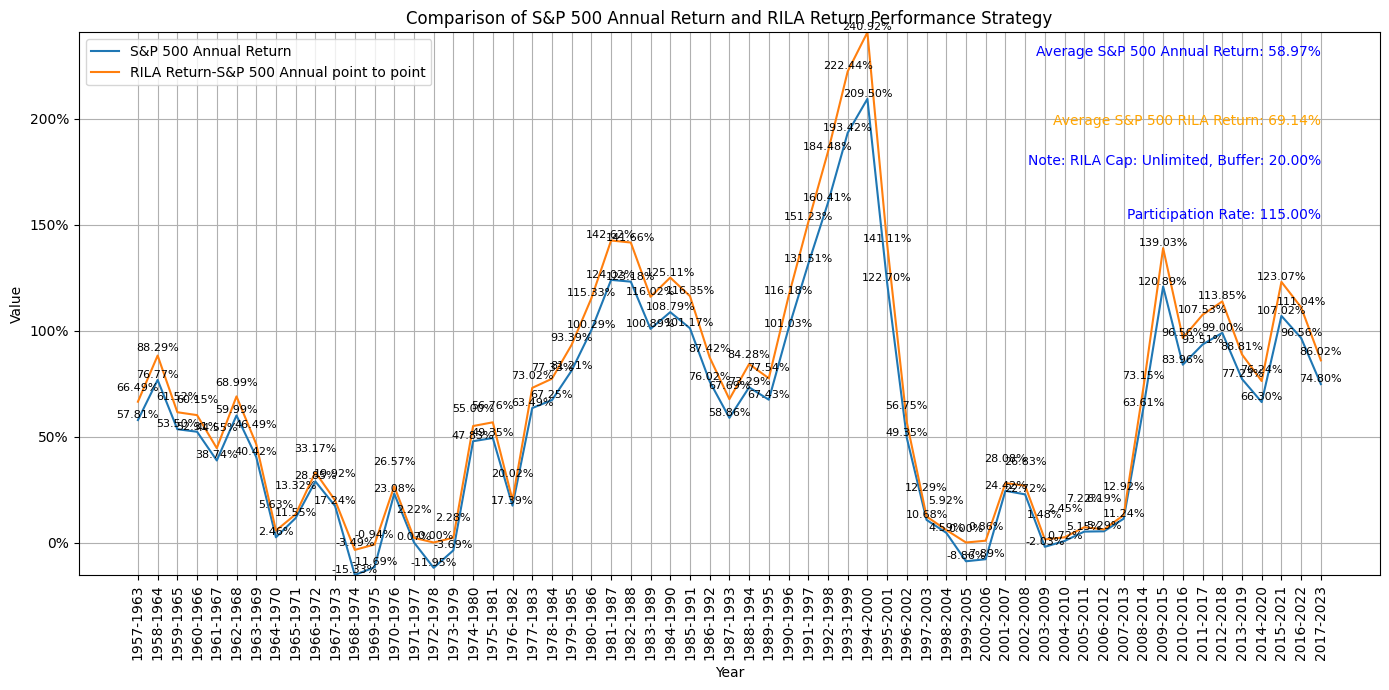

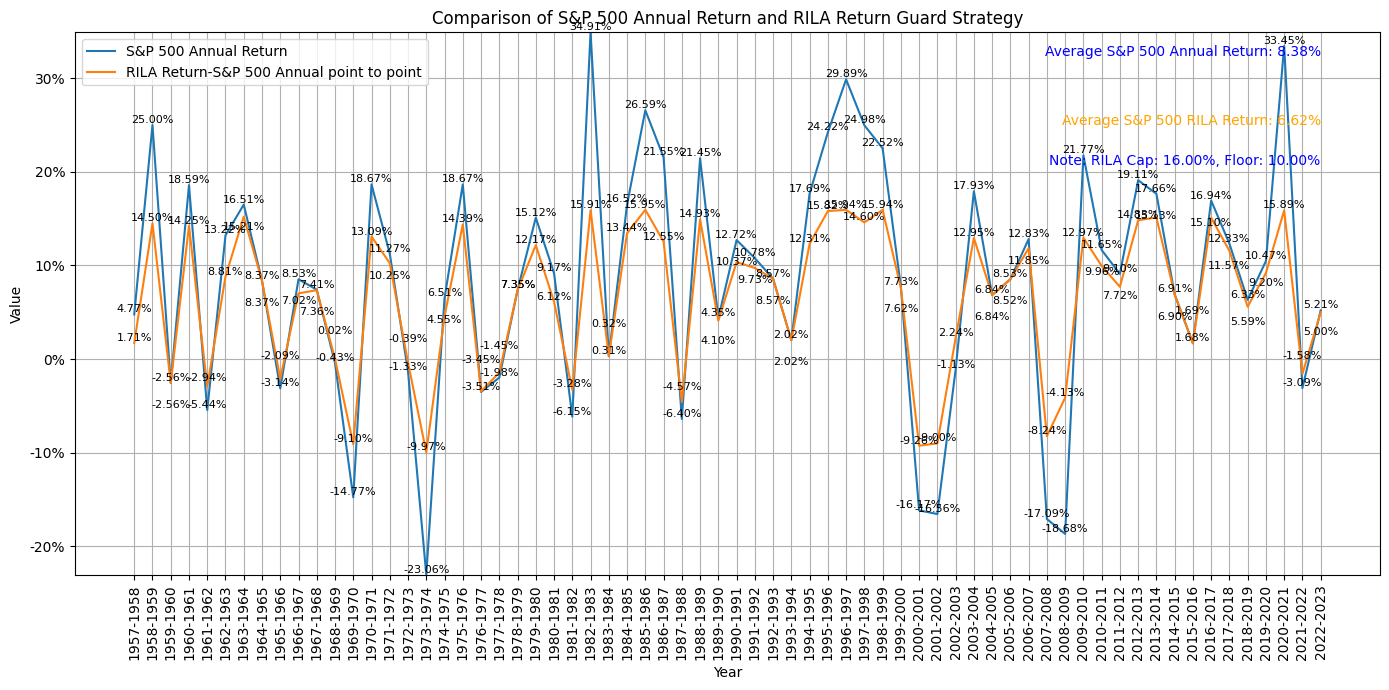

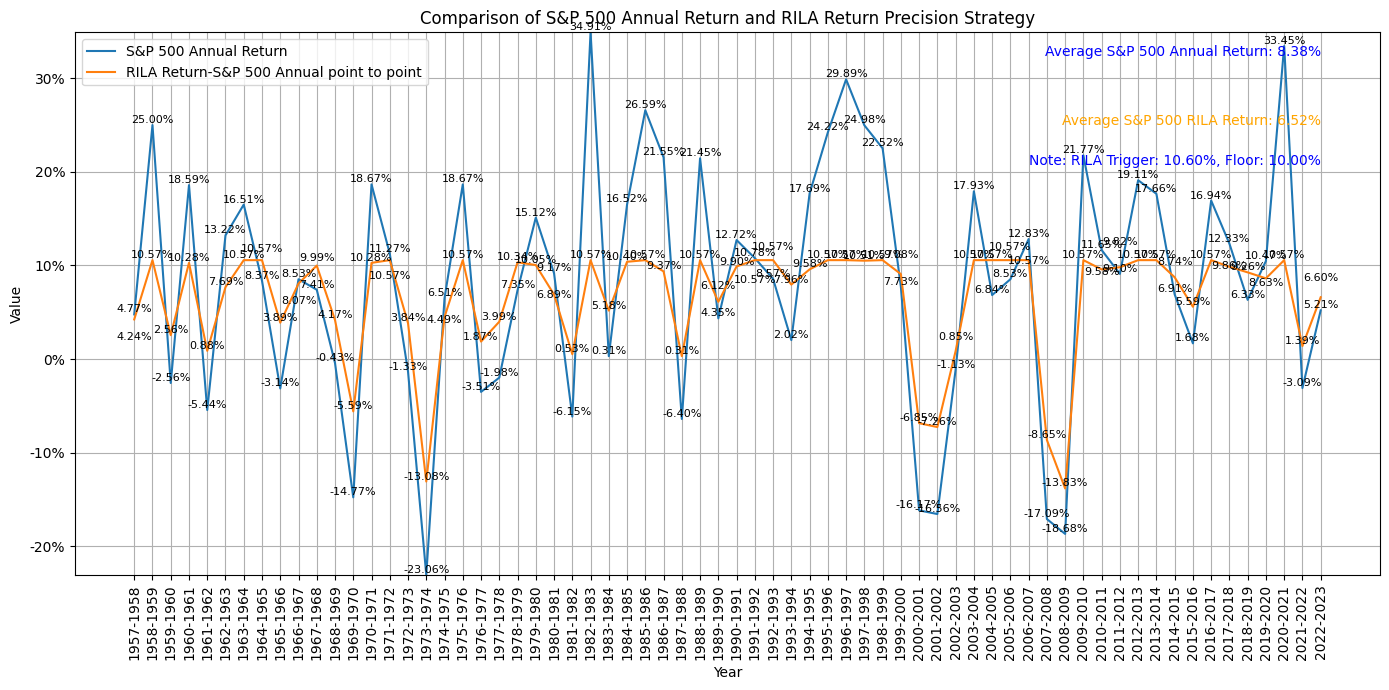

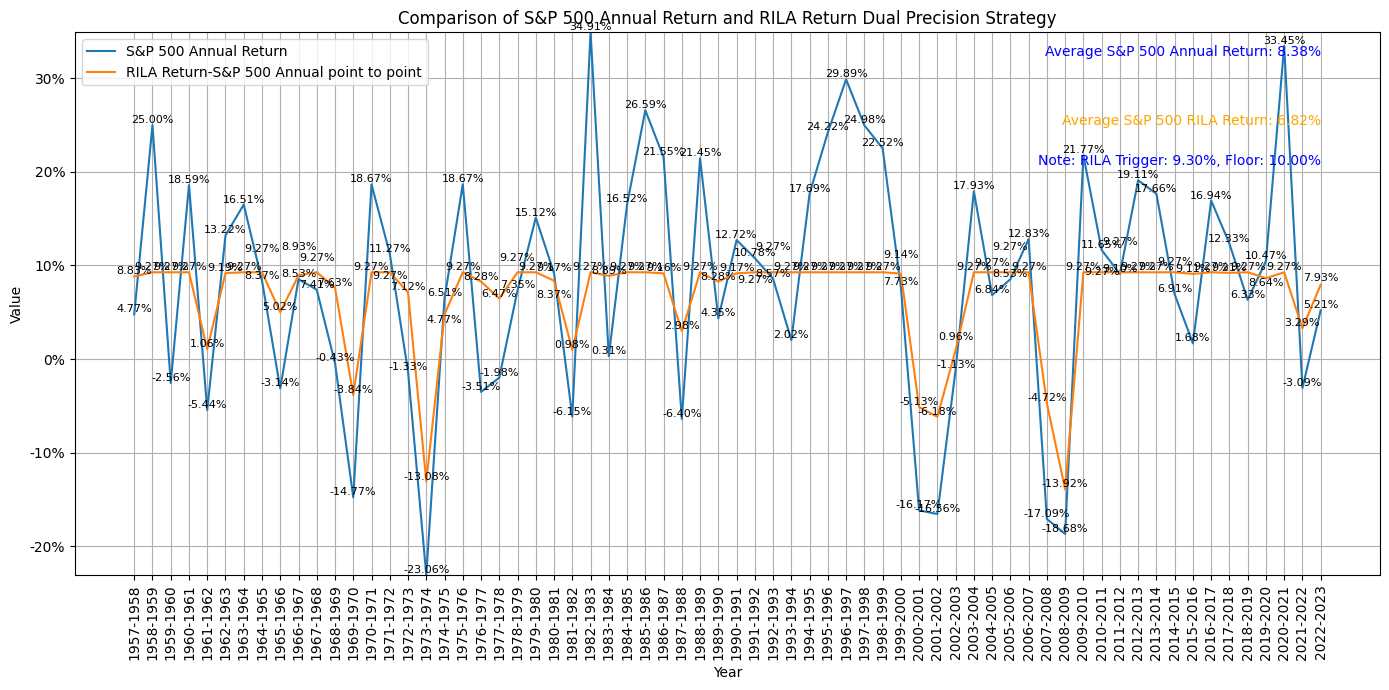

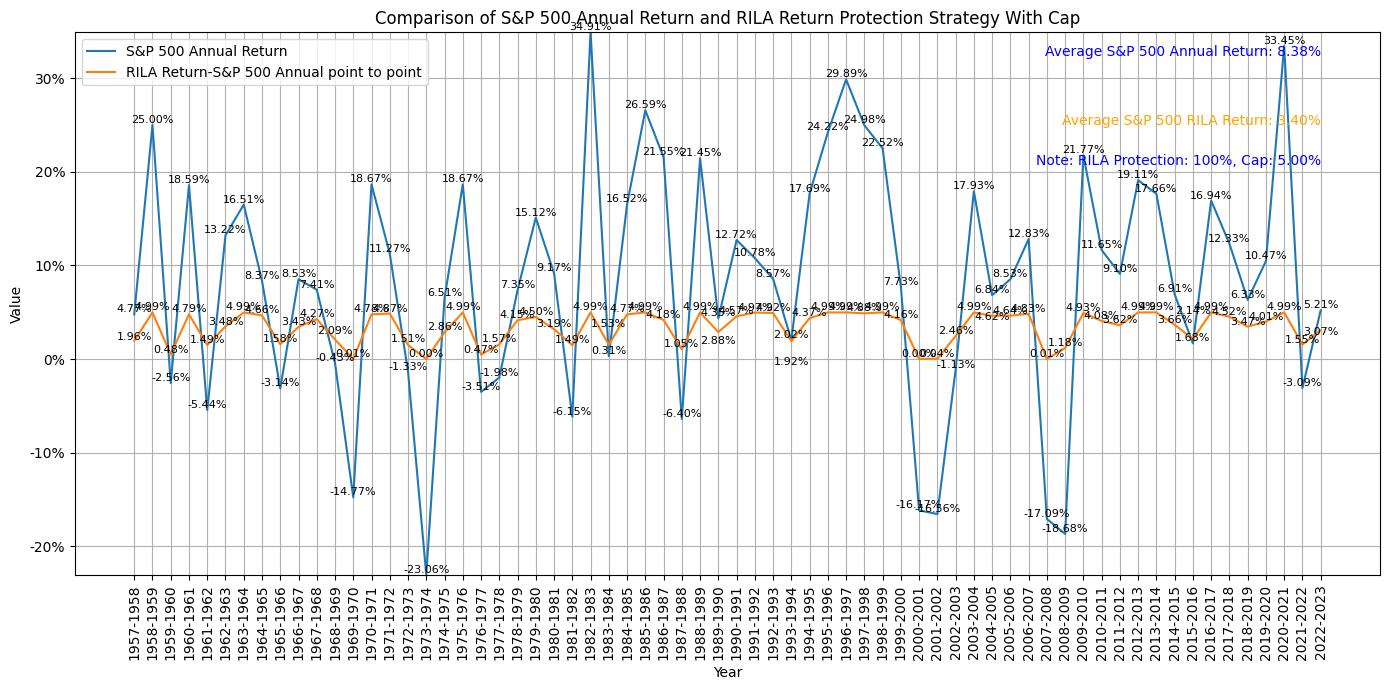

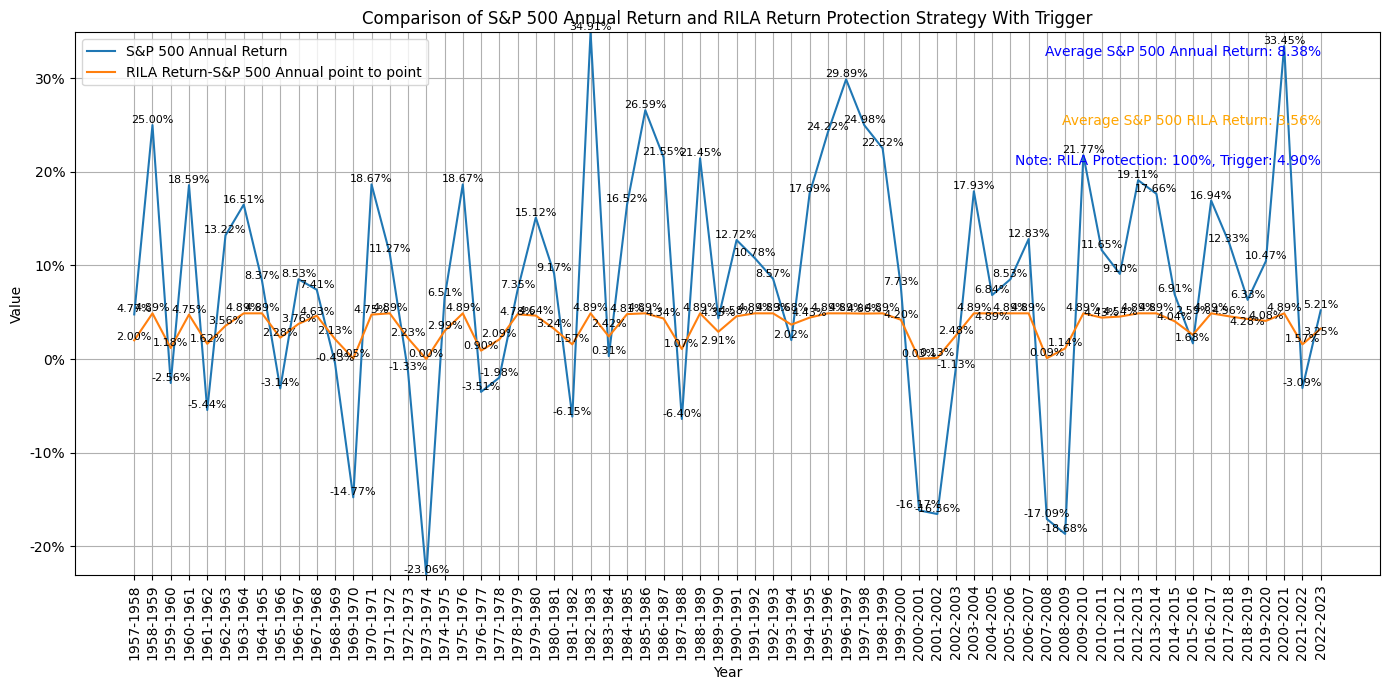

In [232]:
sp500data = pd.read_csv('sp500_data_with_weekends.csv')
russelldata = pd.read_csv('Russell 2000_data_with_weekends.csv')
nasdaqdata = pd.read_csv('Nasdaq_data_with_weekends.csv')
EAFdata = pd.read_csv('MSCI-EAFE_with_weekends.csv')
EEMdata = pd.read_csv('MSCI-Emerging_with_weekends.csv')
DSIdata = pd.read_csv('MSCI-KLD-400_with_weekends.csv')
STOXX50data = pd.read_csv('EURO-STOXX-50_with_weekends.csv')

RILAcapBuffer(sp500data, 1957, 2023, 1000, 'S&P 500', 0.2, 6, 1.15)
RILAcapFloor(sp500data, 1957, 2023, 0.16, 'S&P 500', 0.1, 1)
RILATriggerBuffer(sp500data, 1957, 2023, 0.106, 'S&P 500', 0.1, 1)
RILADualTriggerBuffer(sp500data, 1957, 2023, 0.093, 'S&P 500', 0.1, 1)
RILAProtectionCap(sp500data, 1957, 2023, 0.05, 'S&P 500',  1)
RILAProtectionTrigger(sp500data, 1957, 2023, 0.049, 'S&P 500',  1)

In [183]:
def RILASP500LossPercentage(data, start_year, end_year,  buffer, duration):

    startyear = start_year
    # Set index and convert date column to datetime
    data.set_index('Date', inplace=True)
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])

    RILA = []
    count = 0
    countLoss = 0
    while start_year + duration <= end_year:
        CurYearData = data[data['Date'].dt.year == start_year]
        CurYearData.reset_index(inplace=True)
        CurYearData = CurYearData['Adj Close']
        NextYearData = data[data['Date'].dt.year == start_year + duration]
        NextYearData.reset_index(inplace=True)
        NextYearData = NextYearData['Adj Close']
        for i in range(0, len(CurYearData) - 1):
            count = count + 1
            inc = NextYearData[i] / CurYearData[i] - 1
            if inc < 0 - buffer: 
                countLoss = countLoss + 1
            
        start_year += 1
    countPos = count - countLoss
    percentagePos = countPos/count * 100
    percentageLos = countLoss/count * 100
    
    #print(f'Count: {count}, Loss Percentage: {percentage:.2f}%')

    labels = ['Losses', 'Gains']
    sizes = [countLoss, countPos]
    colors = ['gold', 'brown']

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    ax[0].set_title('Percentage of Positive and Negative Results')

    ax[1].axis('off')  # Hide axes
    
    info_text = (
        f"Number of {duration} years period: {count}\n"
        f"Number of Gains: {countPos} ({percentagePos:.1f}%)\n"
        f"Number of Losses: {countLoss} ({percentageLos:.1f}%)\n"
    )

    # Display the information box
    ax[1].text(0.5, 0.5, info_text, ha="center", fontsize=12, bbox={"facecolor":"lightblue", "alpha":0.5, "pad":10})

    plt.show()

    

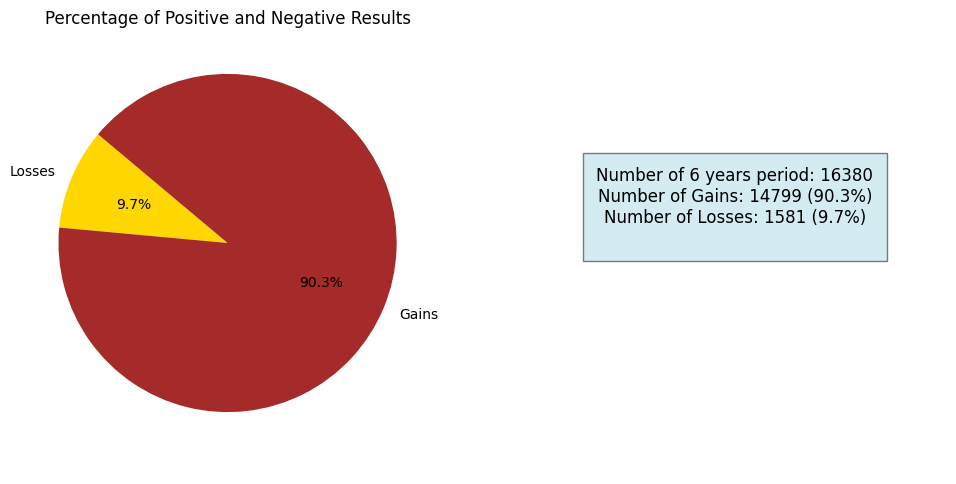

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sp500data = pd.read_csv('sp500_data_with_weekends.csv')
RILASP500LossPercentage(sp500data,1973,2023,0,6)


In [185]:
def RILASP500BoxChart6year(data, start_year, end_year, duration = 6):

    startyear = start_year
    # Set index and convert date column to datetime
    data.set_index('Date', inplace=True)
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])

    RILA = []
    count = 0
    countLoss = 0
    countLoss10 = 0
    countLoss15 = 0
    countLoss20 = 0
    countLoss30 = 0
    countLossOver = 0
    countPos100 = 0
    countPos150 = 0
    countPos200 = 0
    countPosOver = 0
    totalInc = 0
    LosInc = 0
    LosInc10 = 0
    LosInc15 = 0
    LosInc20 = 0
    LosInc30 = 0
    LosIncOver = 0
    posInc = 0
    posInc100 = 0
    posInc150 = 0
    posInc200 = 0
    posIncOver = 0
    while start_year + duration <= end_year:
        CurYearData = data[data['Date'].dt.year == start_year]
        CurYearData.reset_index(inplace=True)
        CurYearData = CurYearData['Adj Close']
        NextYearData = data[data['Date'].dt.year == start_year + duration]
        NextYearData.reset_index(inplace=True)
        NextYearData = NextYearData['Adj Close']
        for i in range(0, len(CurYearData) - 1):
            count = count + 1
            inc = NextYearData[i] / CurYearData[i] - 1
            totalInc = totalInc + inc
            if inc < 0: 
                countLoss = countLoss + 1
                LosInc += inc
                if inc >= -0.1:
                    countLoss10 += 1
                    LosInc10 += inc
                elif inc >= -0.15:
                    countLoss15 += 1
                    LosInc15 += inc
                elif inc >= -0.2:
                    countLoss20 += 1
                    LosInc20 += inc
                elif inc >= -0.3:
                    countLoss30 += 1
                    LosInc30 += inc
                else: 
                    countLossOver += 1
                    LosIncOver += inc
            else:
                posInc += inc
                if inc < 1:
                    posInc100 += inc
                    countPos100 += 1
                elif inc >= 1 and inc < 1.5:
                    posInc150 += inc
                    countPos150 += 1
                elif inc >= 1.5 and inc < 2:
                    posInc200 += inc
                    countPos200 += 1
                else:
                    posIncOver += inc
                    countPosOver += 1
        start_year += 1
    countPos = count - countLoss
    totalInc = totalInc / count * 100
    percentagePos = countPos/count * 100
    LosInc = LosInc / countLoss * 100
    percentageLos = countLoss/count * 100
    posInc = posInc / countPos * 100
        
    percentageLos10 = countLoss10 / count * 100
    if LosInc10 != 0:
        LosInc10 = LosInc10 / countLoss10 * 100
    percentageLos15 = countLoss15 / count * 100
    if LosInc15 != 0:
        LosInc15 = LosInc15 / countLoss15 * 100
    percentageLos20 = countLoss20 / count * 100
    if LosInc20 != 0:
        LosInc20 = LosInc20 / countLoss20 * 100
    percentageLos30 = countLoss30 / count * 100
    if LosInc30 != 0:
        LosInc30 = LosInc30 / countLoss30 * 100
    percentageLosOver = countLossOver / count * 100
    if LosIncOver != 0:
        LosIncOver = LosIncOver / countLossOver * 100
    percentagePos100 = countPos100 / count * 100
    if posInc100 != 0:
        posInc100 = posInc100 / countPos100 * 100
    percentagePos150 = countPos150 / count * 100
    if posInc150 != 0:
        posInc150 = posInc150 / countPos150 * 100
    percentagePos200 = countPos200 / count * 100
    if posInc200 != 0:
        posInc200 = posInc200 / countPos200 * 100
    percentagePosOver = countPosOver / count * 100
    if posIncOver != 0:
        posIncOver = posIncOver / countPosOver * 100
    
    
    #print(f'Count: {count}, Loss Percentage: {percentage:.2f}%')

    labels = ['Losses', 'Gains']
    sizes = [countLoss, countPos]
    colors = ['Silver', 'brown']

    fig, ax = plt.subplots(figsize=(8, 8))
    
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=270)
    descriptions = [f'Gains: {percentagePos:.1f}% ({countPos}Times)', f'Loss: {percentageLos:.1f}% ({countLoss}Times)']
    positions = [(0.1, 0.8), (-0.6, -0.8)]
    ax.set_title('S&P 500 6-year Index Return')

    for i, wedge in enumerate(wedges):
        ax.annotate(descriptions[i], xy=(wedge.theta2, wedge.r/2), xytext=positions[i],
                textcoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='center', verticalalignment='center', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightyellow"))

    plt.show()

    # Display the information box
    #ax[1].text(0.5, 0.5, info_text, ha="center", fontsize=12, bbox={"facecolor":"lightblue", "alpha":0.5, "pad":10})
    data = {
        "Description": ["6-year Period Average Return", "Total Counts", "Number of Gains", "Number of Losses", 
                       "Number Of Gains Within Each Category", "Time gains occurred between 1-100%", 
                        "Time gains occurred between 100-150%", "Time gains occurred between 150-200%", "Time gains exceeded 200%",
                       "Number Of Loss Within Each Category","Time Loss occurred between 1-10%","Time Loss occurred between 10-15%",
                        "Time Loss occurred between 15-20%","Time Loss occurred between 20-30%","Time Loss exceeded 30%"],
        "Count and Percentage": ['-', f'{count}, 100%', f'{countPos}, {percentagePos:.1f}%', f'{countLoss}, {percentageLos:.1f}%', 
                                 f'{countPos}, {percentagePos:.1f}%', f'{countPos100}, {percentagePos100:.1f}%',f'{countPos150}, {percentagePos150:.1f}%',
                                 f'{countPos200}, {percentagePos200:.1f}%',f'{countPosOver}, {percentagePosOver:.1f}%',
                    f'{countLoss}, {percentageLos:.1f}%', f'{countLoss10}, {percentageLos10:.1f}%',f'{countLoss15}, {percentageLos15:.1f}%',
                    f'{countLoss20}, {percentageLos20:.1f}%',f'{countLoss30}, {percentageLos30:.1f}%',f'{countLossOver}, {percentageLosOver:.1f}%'],
        "Average Return":[f'{totalInc:.1f}%', '-', '-', '-', f'{posInc:.1f}%', f'{posInc100:.1f}%',f'{posInc150:.1f}%',
                          f'{posInc200:.1f}%',f'{posIncOver:.1f}%',f'{LosInc:.1f}%', f'{LosInc10:.1f}%',f'{LosInc15:.1f}%',f'{LosInc20:.1f}%'
                          ,f'{LosInc30:.1f}%',f'{LosIncOver:.1f}%']
    }

    df = pd.DataFrame(data)
    
    def highlight_row(row):
        if row.name == 1 or row.name == 4 or row.name == 9: 
            return ['background-color: orange'] * len(row)
        else:
            return [''] * len(row)

    styled_df = df.style.apply(highlight_row, axis=1) \
    .set_table_styles([
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '18pt'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center'), ('background-color', '#d3d3d3')]},
        {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
        {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
    ]).set_caption("Summary of 6-year Period Performance Data") \
    .set_properties(**{'border': '1px solid black'}) \
    .hide(axis='index')

    styled_df.to_excel('6-Year Results.xlsx', engine='openpyxl', index=False)

    return styled_df

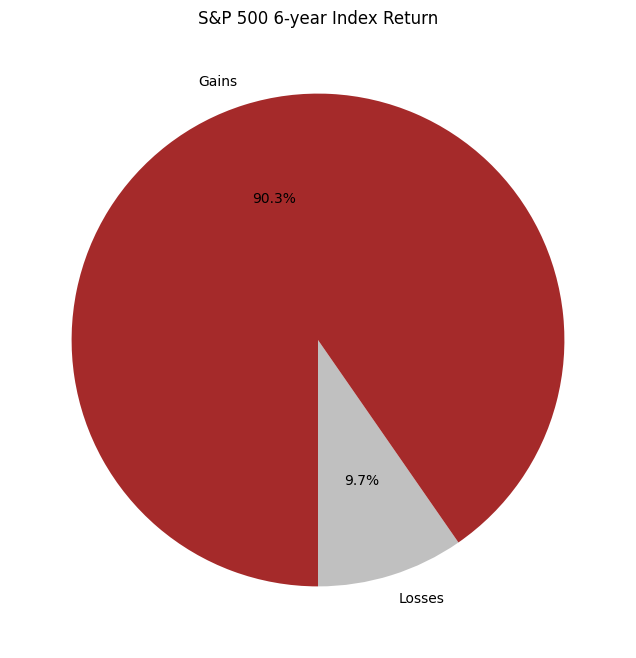

Description,Count and Percentage,Average Return
6-year Period Average Return,-,70.7%
Total Counts,"16380, 100%",-
Number of Gains,"14799, 90.3%",-
Number of Losses,"1581, 9.7%",-
Number Of Gains Within Each Category,"14799, 90.3%",79.0%
Time gains occurred between 1-100%,"10442, 63.7%",53.8%
Time gains occurred between 100-150%,"3091, 18.9%",119.9%
Time gains occurred between 150-200%,"882, 5.4%",175.7%
Time gains exceeded 200%,"384, 2.3%",213.8%
Number Of Loss Within Each Category,"1581, 9.7%",-7.0%


In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sp500data = pd.read_csv('sp500_data_with_weekends.csv')
RILASP500BoxChart6year(sp500data,1973,2023)


In [187]:
def RILASP500BoxChartDuration(data, start_year, end_year):

    startyear = start_year
    # Set index and convert date column to datetime
    data.set_index('Date', inplace=True)
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])

    RILA = []
    count = 0
    countLoss = 0
    countLoss10 = 0
    countLoss15 = 0
    countLoss20 = 0
    countLoss25 = 0
    countLoss30 = 0
    countLoss35 = 0
    countLoss40 = 0
    countLoss45 = 0
    countLoss50 = 0
    yearList = []
    durationList = [1,2,3,6]
    for i in durationList:
        while start_year + i <= end_year:
            CurYearData = data[data['Date'].dt.year == start_year]
            CurYearData.reset_index(inplace=True)
            CurYearData = CurYearData['Adj Close']
            NextYearData = data[data['Date'].dt.year == start_year + i]
            NextYearData.reset_index(inplace=True)
            NextYearData = NextYearData['Adj Close']
            temp = 0
            if NextYearData[0] == 0:
                tmpdata = data[data['Date'].dt.year == start_year + i - 1]
                tmpdata.reset_index(inplace=True)
                tmpdata = tmpdata['Adj Close']
                k = len(tmpdata)
                while temp == 0:
                    temp = tmpdata[k-1]
                    k = k - 1
                
            for j in range(0, len(CurYearData) - 1):
                if CurYearData[j] == 0:
                    continue
                cur = NextYearData[j]
                if cur == 0:
                    cur = temp
                else:
                    temp = cur
                    
                count = count + 1
                inc = cur / CurYearData[j] - 1
                if inc < 0: 
                    countLoss += 1
                    if inc >= -0.1:
                        countLoss10 += 1
                    elif inc >= -0.15:
                        countLoss15 += 1
                    elif inc >= -0.2:
                        countLoss20 += 1
                    elif inc >= -0.25:
                        countLoss25 += 1
                    elif inc >= -0.3:
                        countLoss30 += 1
                    elif inc >= -0.35:
                        countLoss35 += 1
                    elif inc >= -0.40:
                        countLoss40 += 1
                    elif inc >= -0.45:
                        countLoss45 += 1
                    elif inc >= -0.50:
                        countLoss50 += 1
            start_year += 1
        start_year = startyear
        percentageLos = countLoss / count * 100
        percentageLos10 = countLoss10 / count * 100
        percentageLos15 = countLoss15 / count * 100
        percentageLos20 = countLoss20 / count * 100
        percentageLos25 = countLoss25 / count * 100
        percentageLos30 = countLoss30 / count * 100
        percentageLos35 = countLoss35 / count * 100
        percentageLos40 = countLoss40 / count * 100
        percentageLos45 = countLoss45 / count * 100
        percentageLos50 = countLoss50 / count * 100
        curList = [f'{percentageLos:.1f}%',f'{percentageLos10:.1f}%',f'{percentageLos15:.1f}%',f'{percentageLos20:.1f}%',
                   f'{percentageLos25:.1f}%',f'{percentageLos30:.1f}%',f'{percentageLos35:.1f}%',
                   f'{percentageLos40:.1f}%',f'{percentageLos45:.1f}%',f'{percentageLos50:.1f}%',count]
        yearList.append(curList)
        countLoss = 0
        countLoss10 = 0
        countLoss15 = 0
        countLoss20 = 0
        countLoss25 = 0
        countLoss30 = 0
        countLoss35 = 0
        countLoss40 = 0
        countLoss45 = 0
        countLoss50 = 0
        count = 0

    data = {
        "Buffer Levels": ["0%", "-10%", "-15%", "-20%", "-25%", "-30%", "-35%", "-40%", "-45%", "-50%", "Total Outcomes"],
        "1-year": yearList[0],
        "2-year": yearList[1],
        "3-year": yearList[2],
        "6-year": yearList[3]
    }

    df = pd.DataFrame(data)
    styled_df = df.style.set_table_styles([
    {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '18pt'), ('font-weight', 'bold')]},
    {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center'), ('background-color', '#d3d3d3')]},
    {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
]).set_caption("S&P 500 Index Performance Data") \
  .set_properties(**{'border': '1px solid black'}) \
  .hide(axis='index')
    styled_df.to_excel('styled_output.xlsx', engine='openpyxl', index=False)

    return styled_df

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sp500data = pd.read_csv('sp500raw-data.csv')
RILASP500BoxChartDuration(sp500data, 1979, 2023)

Buffer Levels,1-year,2-year,3-year,6-year
0%,22.2%,14.4%,14.1%,9.2%
-10%,10.3%,4.5%,3.6%,6.7%
-15%,4.2%,1.5%,1.0%,2.2%
-20%,3.3%,1.9%,1.4%,0.3%
-25%,2.0%,1.5%,2.5%,0.0%
-30%,0.7%,1.1%,1.7%,0.0%
-35%,0.4%,1.3%,2.2%,0.0%
-40%,0.9%,1.4%,1.3%,0.0%
-45%,0.4%,1.0%,0.5%,0.0%
-50%,0.1%,0.2%,0.1%,0.0%
